# Criação de Modelo - Import bibliotecas

In [45]:
import os
import sys
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from torch.utils.data import RandomSampler, DataLoader, Dataset
from monai.transforms import Compose, ToTensor, RandZoom, apply_transform

In [46]:
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [47]:
import torchvision.models as models
model = models.video.r3d_18(pretrained=True)

In [48]:
path_raw = '../data/raw'
path_data = '../data/processed/train-jpegs'
path_train = '../data/processed'
path_model = '../models/best_model.pth'
path_history = '../models/history.csv'

target_name = 'result_pe'

In [49]:
df = pd.read_csv(path_train+ '/train_apply.csv')

In [50]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  266390 KB |  266390 KB |  266390 KB |       0 B  |
|       from large pool |  259456 KB |  259456 KB |  259456 KB |       0 B  |
|       from small pool |    6934 KB |    6934 KB |    6934 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  266390 KB |  266390 KB |  266390 KB |       0 B  |
|       from large pool |  259456 KB |  259456 KB |  259456 KB |

In [51]:
torch.cuda.set_per_process_memory_fraction(1.0)

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce MX150
Memory Usage:
Allocated: 0.3 GB
Cached:    0.3 GB


# Dataset Pytorch

In [53]:
train_transform = Compose([RandZoom(prob = 0.2, max_zoom= 1.2, min_zoom= 1.2), ToTensor() ])

In [54]:
row = df.iloc[0]

path_img = path_data + '/' + row['StudyInstanceUID'] + '/' + row['SeriesInstanceUID']
imgs_array = sorted([ path_img + '/' + img_path for img_path in listdir(path_img) ])

imgs_input = np.stack([ np.asarray(cv2.imread(img)).astype(np.float32) for img in imgs_array ]).transpose(3,0,1,2)

In [55]:
path_img = path_data + '/' + row['StudyInstanceUID'] + '/' + row['SeriesInstanceUID'] + '.npz'

In [56]:
imgs_input = np.load(path_img)['arr_0']

In [57]:
imgs_input.shape

(3, 32, 112, 112)

In [58]:
def plot_scans(scans, rows = 2, cols = 6 ):
    
    fig,ax = plt.subplots(rows,cols,figsize=[20,6])
    index = 0
    
    for i in range(rows):
        for j in range(cols):
        
            scan = scans[:, index, : , :].transpose(1,2,0)
            ax[i, j].set_title(f'Scan {index+1}')
            ax[i, j].imshow( scan, cmap='bone')
            ax[i, j].axis('off')
            index += 1
            
    plt.show()

In [59]:
scan = imgs_input[: , 20:32 , : , :]

Imagem sem utiliazr técnicas de augmentations

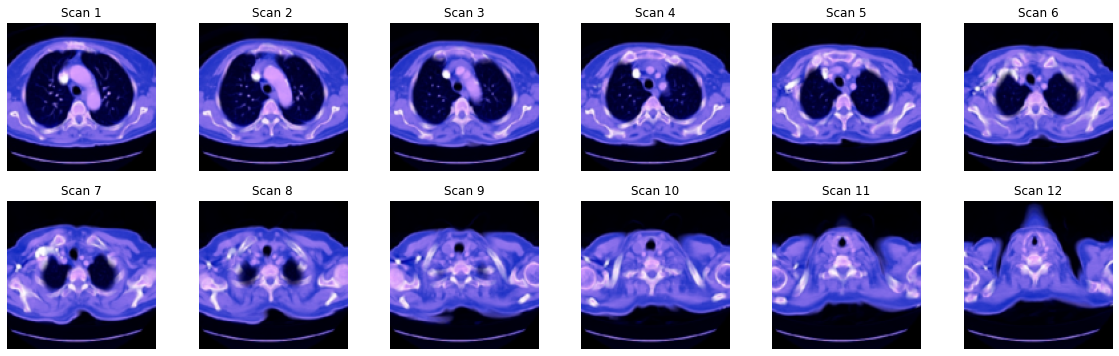

In [60]:
plot_scans(scan)

In [61]:
train_compare = Compose([RandZoom(prob = 1.0, max_zoom= 1.2, min_zoom= 1.2),
                         ToTensor()
                         ])

Transformação da imagem caso ocorra:

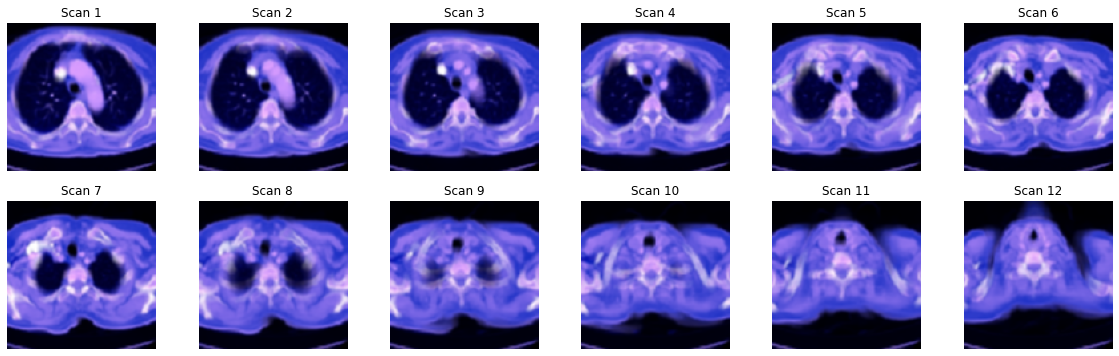

In [62]:
scan_compare = train_compare(scan)

plot_scans(scan_compare.numpy())

# Gerando dataset

In [63]:
class PEDataset(Dataset):
   
    def __init__(self, df, transform=None):
        
        self.transform = transform
        self.df = df
        
        tr = pd.read_csv(path_train+'/train_apply.csv')
    
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, index):
        
        row = self.df.iloc[index]
        
        path_img = path_data + '/' + row['StudyInstanceUID'] + '/' + row['SeriesInstanceUID'] + '.npz'
        imgs_input = np.load(path_img)['arr_0']
    
        if self.transform is not None:
            imgs_input = apply_transform(self.transform, imgs_input)
        
        return imgs_input, torch.tensor(row[target_name]).float()
        

In [64]:
dataset = PEDataset(df, train_transform)

In [65]:
data, target = dataset[0]

In [66]:
print(data.dtype)

torch.float32


Função classificadora

In [67]:
bce = torch.nn.BCEWithLogitsLoss()

def binary_cross_entropy(logits, target): 
    
    y_pred = logits.view(-1)
    y_target = target.view(-1)
    
    loss = bce(y_pred, y_target)
    return loss


# Gerando rede neural

In [68]:
def make_resnet():
    
    model.fc = torch.nn.Sequential(
        nn.Linear(in_features= 512, out_features = 1, bias = True),
    )
        
    return model.to(device)

In [69]:
model = make_resnet()

In [70]:
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [71]:
optimizer = torch.optim.Adam(model.parameters())

In [72]:
def acc_conf_matrix(y_pred, y_target):
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    x_data = torch.tensor(y_pred)
    PROBS = torch.sigmoid(x_data).numpy().squeeze()
    
    for i in range(len(y_pred)):
        
        if y_target[i] == 1 and y_pred[i] >= 0.5:
            TP += 1
            continue
        if y_target[i] == 1 and y_pred[i] < 0.5:
            FP += 1
            continue
        if y_target[i] == 0 and y_pred[i] < 0.5:
            TN += 1
            continue
        if y_target[i] == 0 and y_pred[i] >= 0.5:
            FN += 1
        
    
    return (TP+TN)/(len(y_pred)) , [TP,FP, TN, FN]
        

In [73]:
def train_epoch(model, train_loader, optimizer):
    
    model.train()
    train_loss = []
    y_train = []
    y_target = []
    i = 0
    
    for (data, target) in train_loader:
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        y_pred = model(data)       
        
        loss = binary_cross_entropy(y_pred, target)
        loss.backward()
        optimizer.step()

        train_loss = np.append( train_loss, loss.detach().cpu().numpy() )
        y_train = np.append( y_train, y_pred.detach().cpu().numpy() )
        y_target = np.append( y_target, target.detach().cpu())
        
    acc, _ = acc_conf_matrix(y_train, y_target)
    
    
    return train_loss, acc

In [74]:
# train_epoch(model, train_loader, optimizer)

In [75]:
def val_epoch(model, train_loader):
    
    val_loss = []
    y_val = []
    y_target = []
    
    i = 0
    
    for (data, target) in train_loader:

        data, target = data.to(device), target.to(device)
        y_pred = model(data)      
        loss = binary_cross_entropy(y_pred, target)
        
        val_loss = np.append(val_loss, loss.detach().cpu().numpy() )
        y_val = np.append(y_val, y_pred.detach().cpu())
        y_target = np.append(y_target, target.detach().cpu())
            
    acc, conf_matrix = acc_conf_matrix(y_val, y_target)
    
    return val_loss, acc, conf_matrix


In [76]:
# val_epoch(model, train_loader)

In [77]:
def load_model():
    
    try:
        df_model = pd.read_csv(path_history)
        last_epoch = df_model['epoch'].iloc[-1]
    except:
        df_model = pd.DataFrame(columns=['epoch', 'acc_train', 'acc_val', 'train_loss', 'val_loss', 'TP', 'TN', 'FP', 'FN'])
        return df_model, model, 0
    
    model_load = torch.load(path_model)
    return df_model, model_load, last_epoch
    

In [79]:
def train_model(seed = 0):
    
    np.random.seed(seed)
    msk = np.random.rand(len(df), seed) < 0.8
    pd_history, model, last_epoch = load_model()
    
    df_train = df[msk]
    df_val = df[~msk]
    
    dataset_train = PEDataset(df_train,  train_transform)
    dataset_val = PEDataset(df_val)
    
    train_loader = DataLoader(dataset_train, batch_size = 8, sampler=RandomSampler(dataset_train), num_workers=2)
    val_loader = DataLoader(dataset_val, batch_size = 8, num_workers=2)
    
    num_epochs = 1
    val_best = 10e5
    save_history = 0
    
    print('init train shape', df_train.shape, 'val shape', df_val.shape)
    
    for epoch in range(last_epoch, num_epochs):
        
        train_loss, acc_train = train_epoch(model, train_loader, optimizer)
        val_loss,  acc_val, conf_matrix = val_epoch(model, val_loader)
        
        train_loss  = np.mean(train_loss)
        val_loss = np.mean(val_loss)
        
        pd_history = pd_history.append({
            'epoch': epoch+1, 
            'acc_train': acc_train, 
            'acc_val': acc_val, 
            'train_loss': train_loss,
            'val_loss': val_loss, 
            'TP':conf_matrix[0], 
            'TN':conf_matrix[2], 
            'FP':conf_matrix[1], 
            'FN':conf_matrix[3],
        }, ignore_index=True)

        pd_history.to_csv(path_history, index=False)
        
        if val_loss < val_best:

            val_best = val_loss 
            torch.save(model.state_dict(), path_model)

        print('epoch =', epoch+1, ' acc_train =', acc_train, ' acc_val =', acc_val)
        

In [ ]:
%%time

train_model()

In [38]:
pd_history, _, last_epoch = load_model()

In [39]:
pd_history

,epoch,acc_train,acc_val,train_loss,val_loss,TP,TN,FP,FN
0,1.0,0.661183,0.687673,0.637016,0.621128,0.0,993.0,451.0,0.0
1,2.0,0.673350,0.686981,0.622279,0.612426,53.0,939.0,398.0,54.0
2,3.0,0.688260,0.694598,0.597312,0.595863,127.0,876.0,324.0,117.0
3,4.0,0.718937,0.722299,0.570205,0.581797,115.0,928.0,336.0,65.0
4,5.0,0.738475,0.708449,0.541466,0.590040,149.0,874.0,302.0,119.0
5,6.0,0.766752,0.698061,0.504933,0.591752,66.0,942.0,385.0,51.0
6,7.0,0.802571,0.728532,0.442852,0.650828,145.0,907.0,306.0,86.0
7,8.0,0.857926,0.708449,0.352383,0.672821,179.0,844.0,272.0,149.0
8,9.0,0.895973,0.722299,0.269461,0.773124,171.0,872.0,280.0,121.0
9,10.0,0.924079,0.681440,0.208596,0.741311,242.0,742.0,209.0,251.0


# Resultados

Bom primeiramente é importante destacar que eu não consegui rodar o modelo na minha máquina. Eu tive que utilizar uma máquina do kaggle e acabei gastando minhas horas semanais de kernel rodando esse modelo. Para a geração de 10 epochs foram necessários 5 horas de treinamento em um data set com mais o menos 7000 pacientes.

O modelo da um overfitting tendo uma acurácia de 92% para treinamento e 68% em validação.

Pŕoximas etapas:

• Estudar pré processamento mais eficiente (estou gastando cerca de 20 gb em dados pré processados).

• Aplicar técnias para evitar o overfitting

• Identificar regiões que existe a obstrução da artéria pulmonar (image segmentation)


Mas em geral o modelo apresentou um resultado relativamente bom, uma taxa de acerto de 72% para validação é um bom começo. 